In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [6]:
   
db = CaseDB()
toload = [
    dict(name="afnE_base", id = "d24bd-cond0.25_frec0.48"),
    dict(name="afnE_3e19", id = "d26c-c0.25_f0.48_3e19"),
    dict(name="afnE_2e19", id = "d24bd-cond0.25_frec0.48"),
    # dict(name="afn_new_cond0.1", id = "d21a-cond_alpha_0.1")
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

[autoreload of importlib_metadata._adapters failed: Traceback (most recent call last):
  File "c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\mikek\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\importlib_metadata\_adapters.py", line 8, in <module>
    from ._compat import pypy_partial
ImportError: cannot import name 'pypy_part

- Reading case d24bd-cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 10/16/2023, 10:34:08, dmp file date 10/15/2023, 23:08:48

- Reading case d26c-c0.25_f0.48_3e19
-----------------------
- Looking for squash file
- Squash file found. squash date 12/21/2023, 15:24:02, dmp file date 10/20/2023, 15:23:04

- Reading case d24bd-cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 10/16/2023, 10:34:08, dmp file date 10/15/2023, 23:08:48



In [7]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [10]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_base
Loading afnE_base with new AFN
afnE_3e19
Loading afnE_3e19 with new AFN
afnE_2e19
Loading afnE_2e19 with new AFN


# Read SOLEDGE CSV data

In [11]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [12]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

# Simple plots

## 3e19

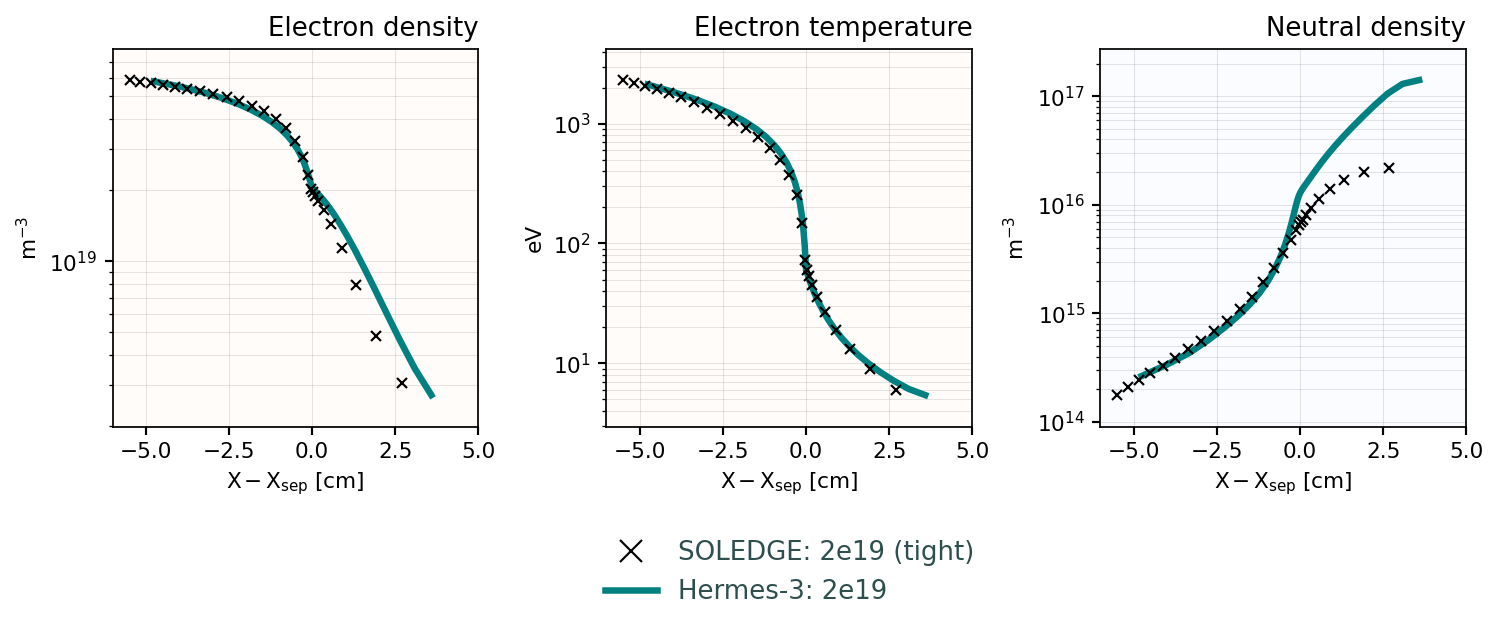

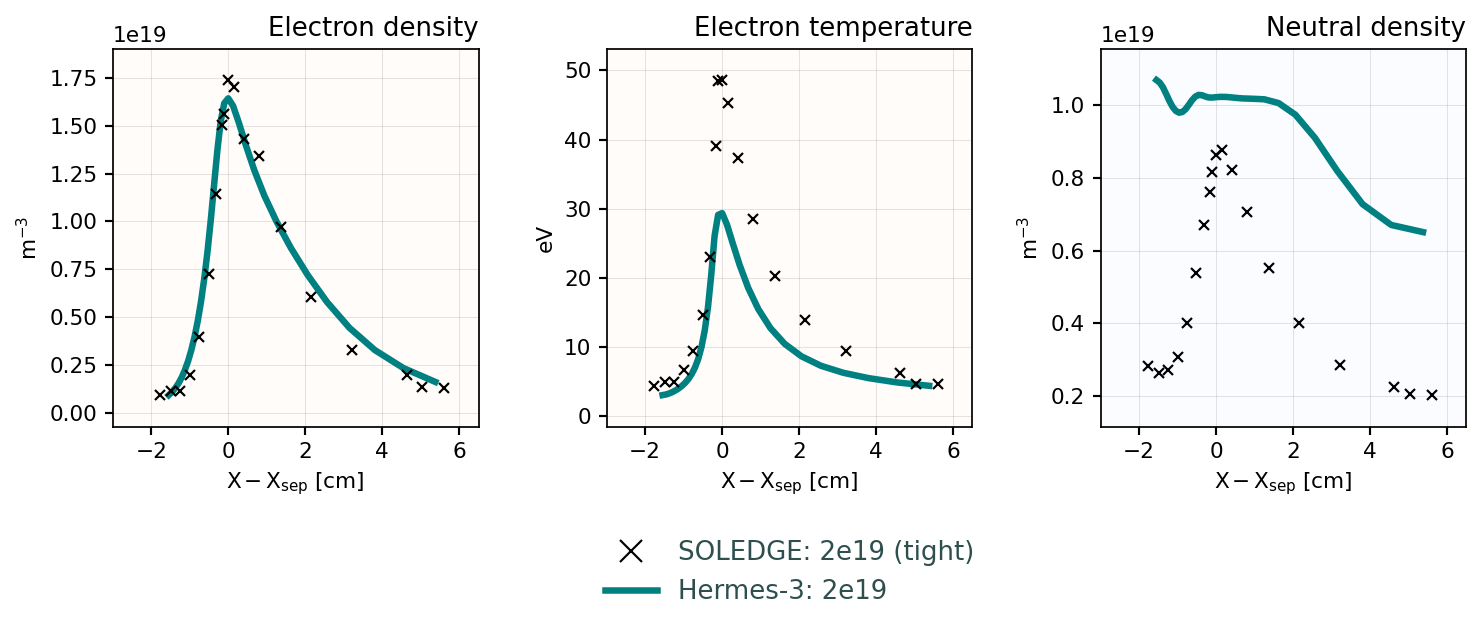

In [13]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: 2e19" : dict(data=hr['afnE_2e19'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Na"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = False,
    mode = "log",
    dpi = 120,
    lw = 2
)

## 3e19

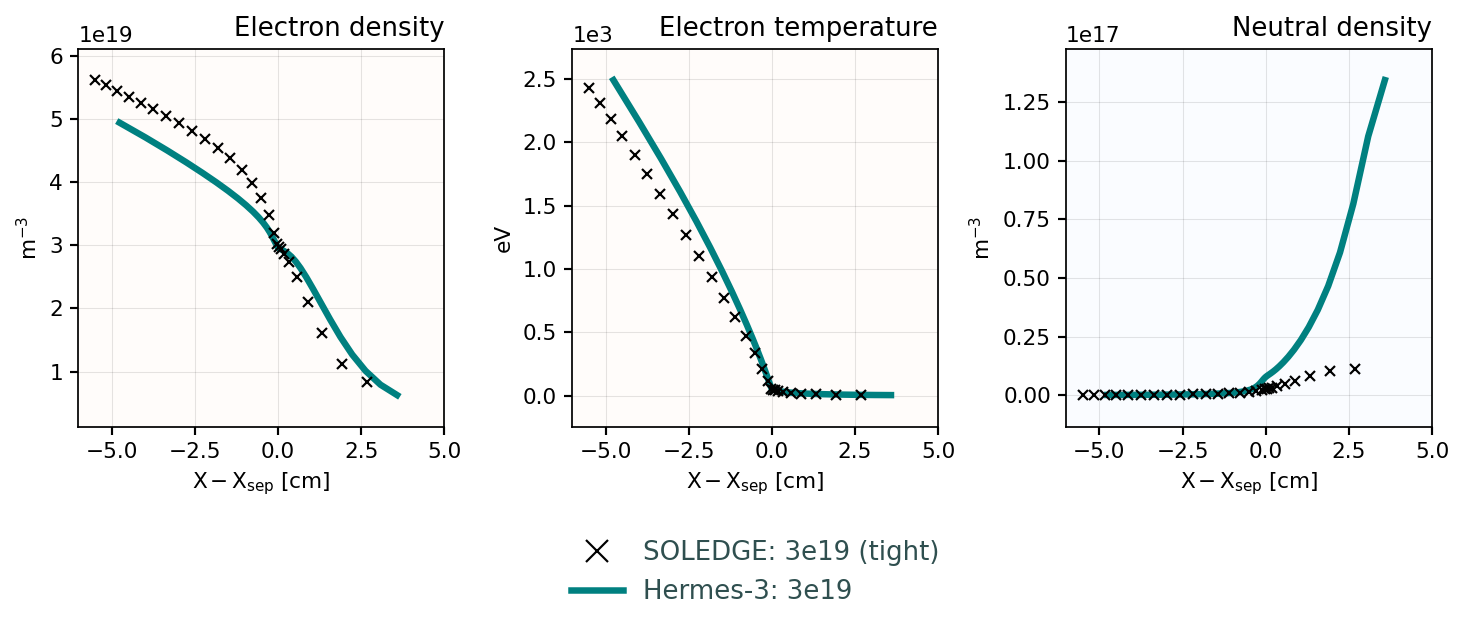

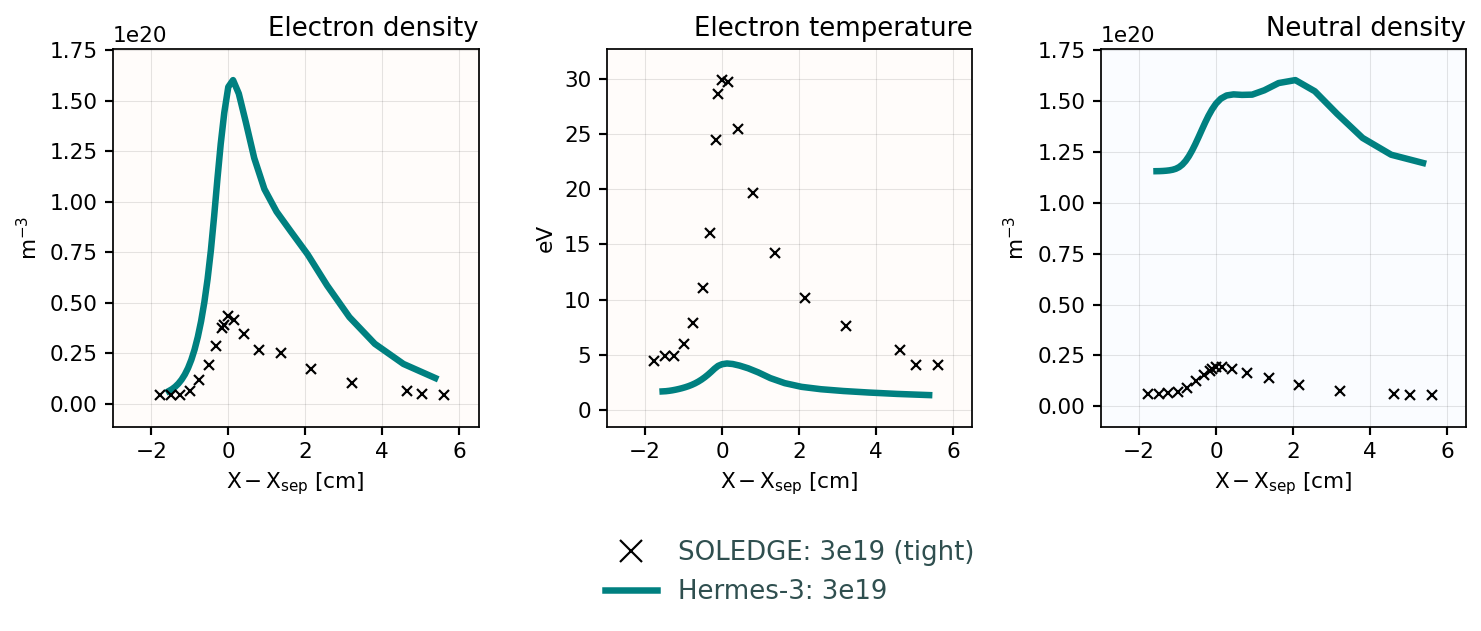

In [15]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 3e19 (tight)" : dict(data=sl["tightwall_3e19"], color="black"),
    r"Hermes-3: 3e19" : dict(data=hr['afnE_3e19'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "outer_lower"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Na"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = False,
    mode = "linear",
    dpi = 120,
    lw = 2
)

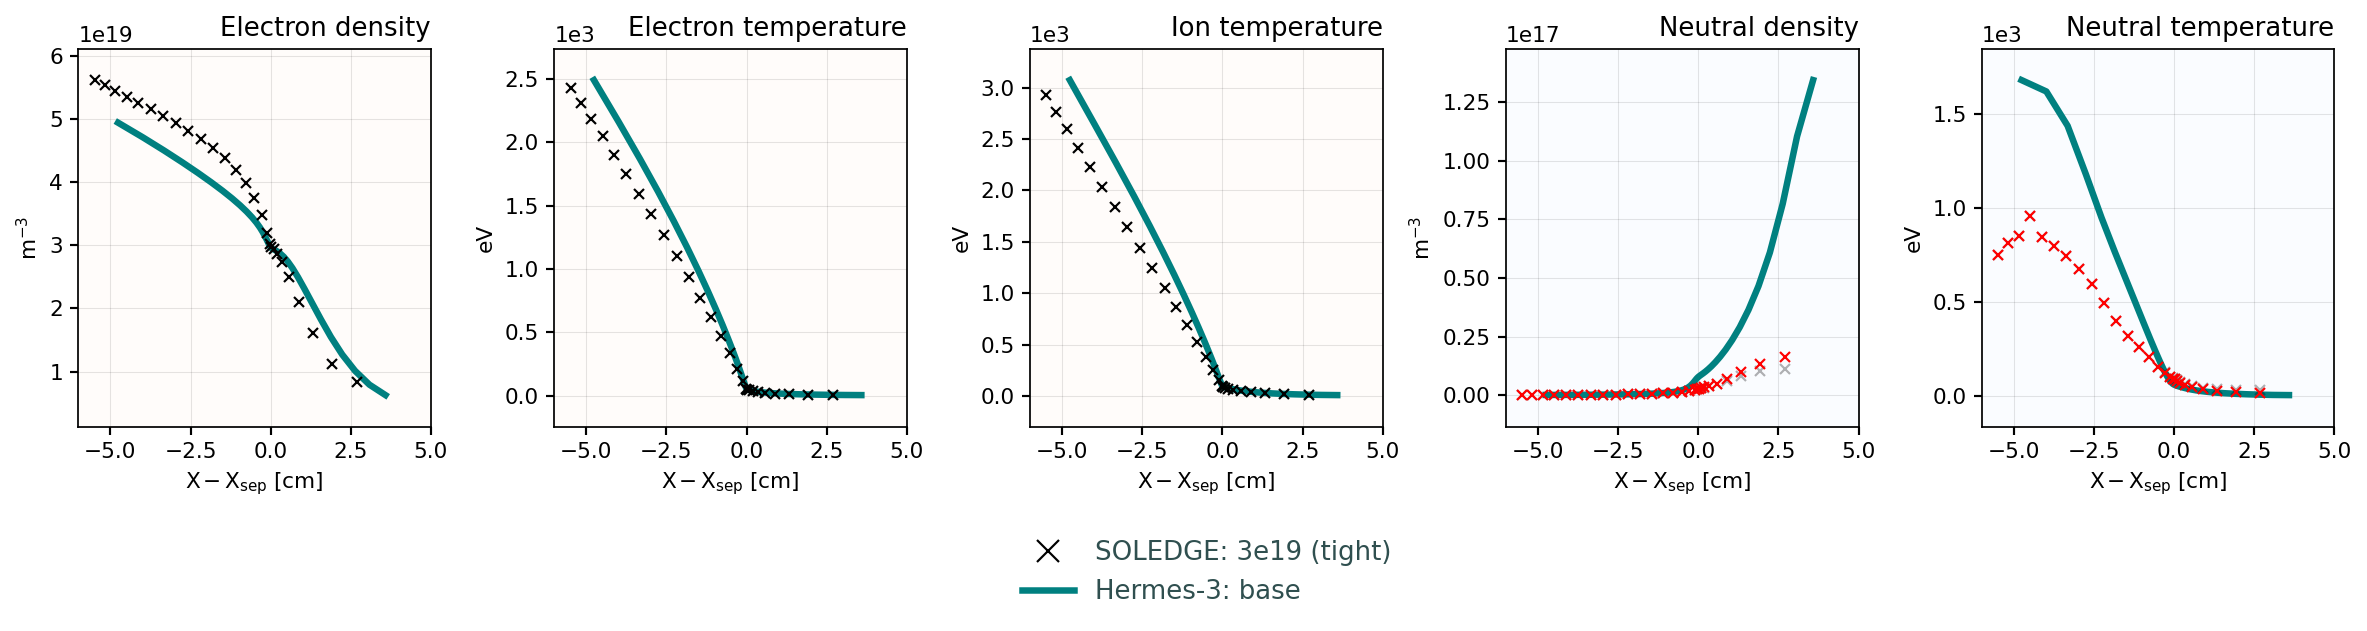

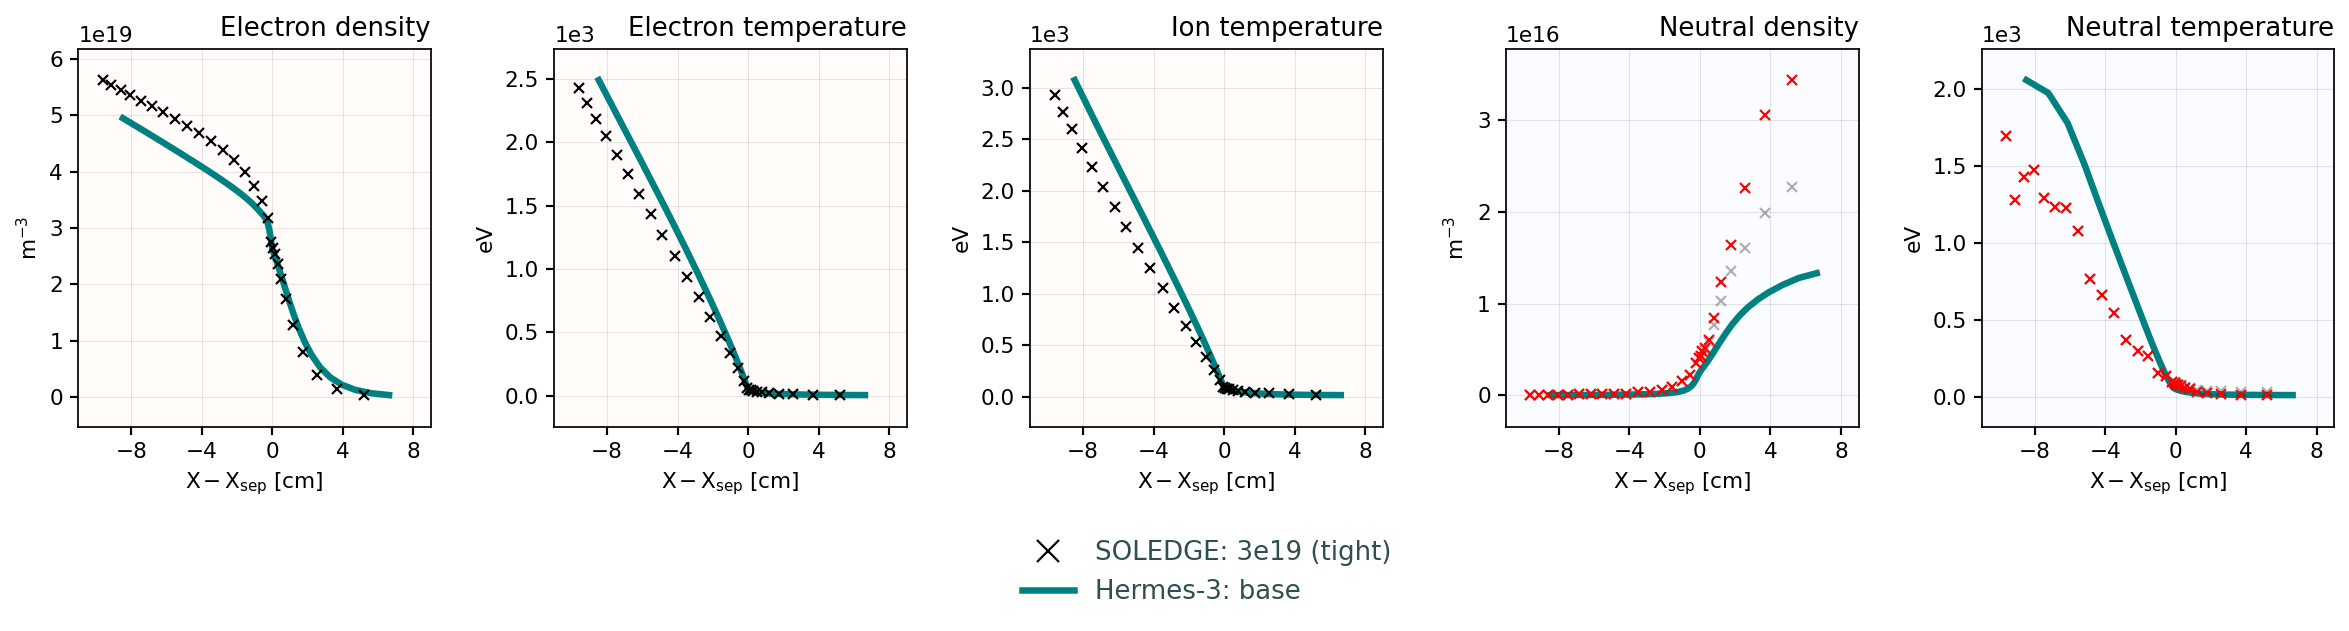

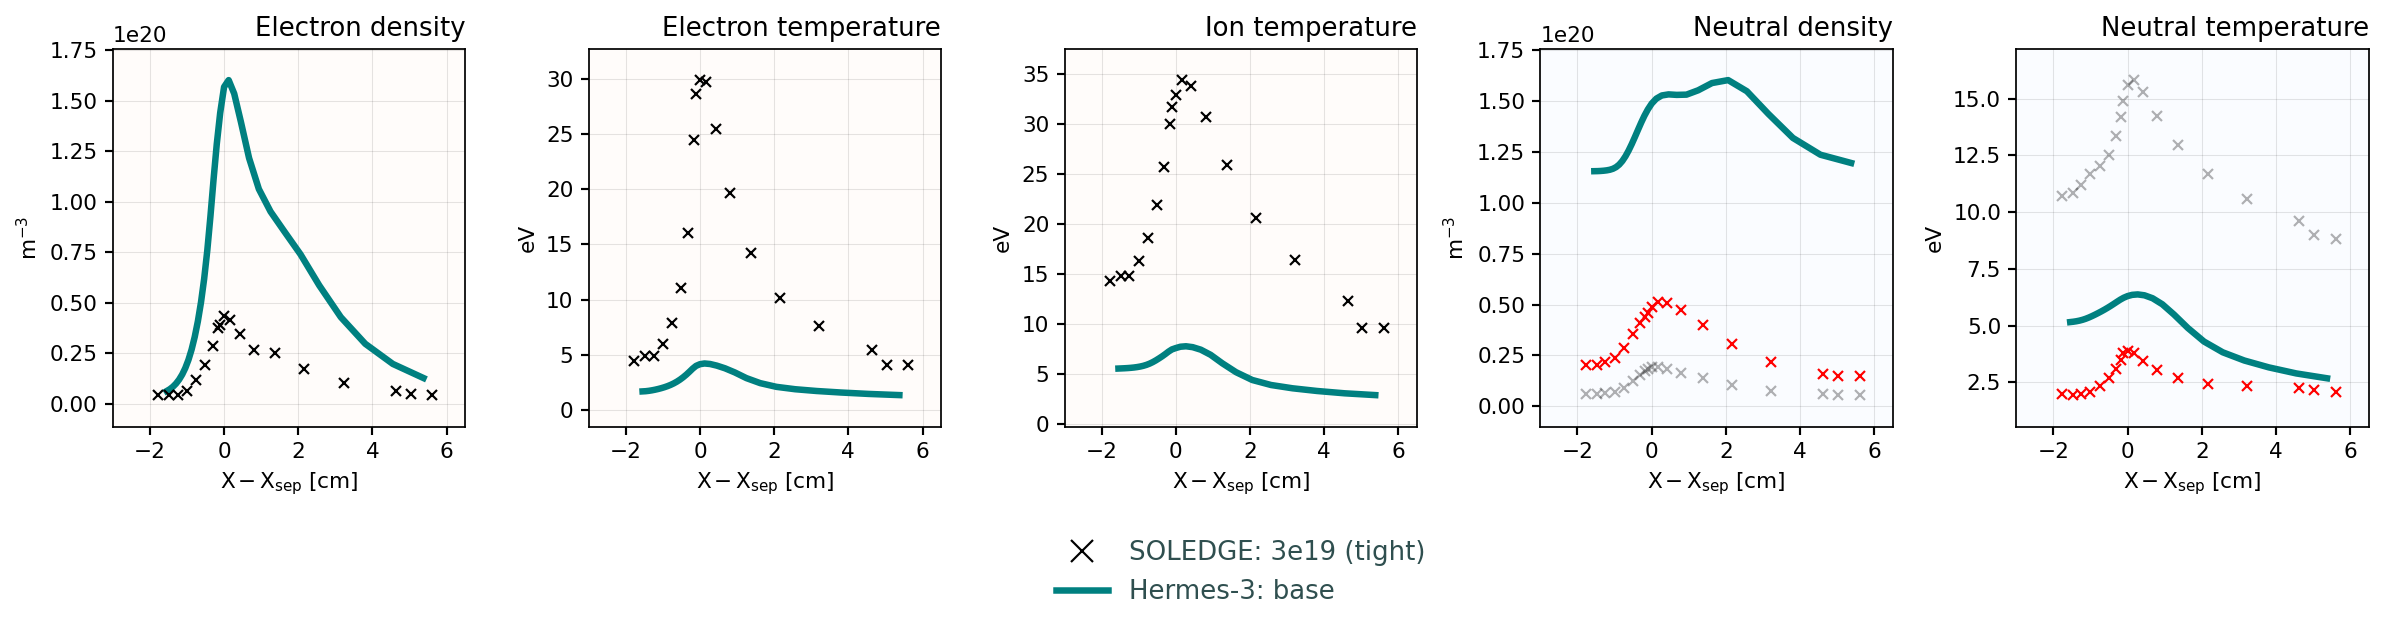

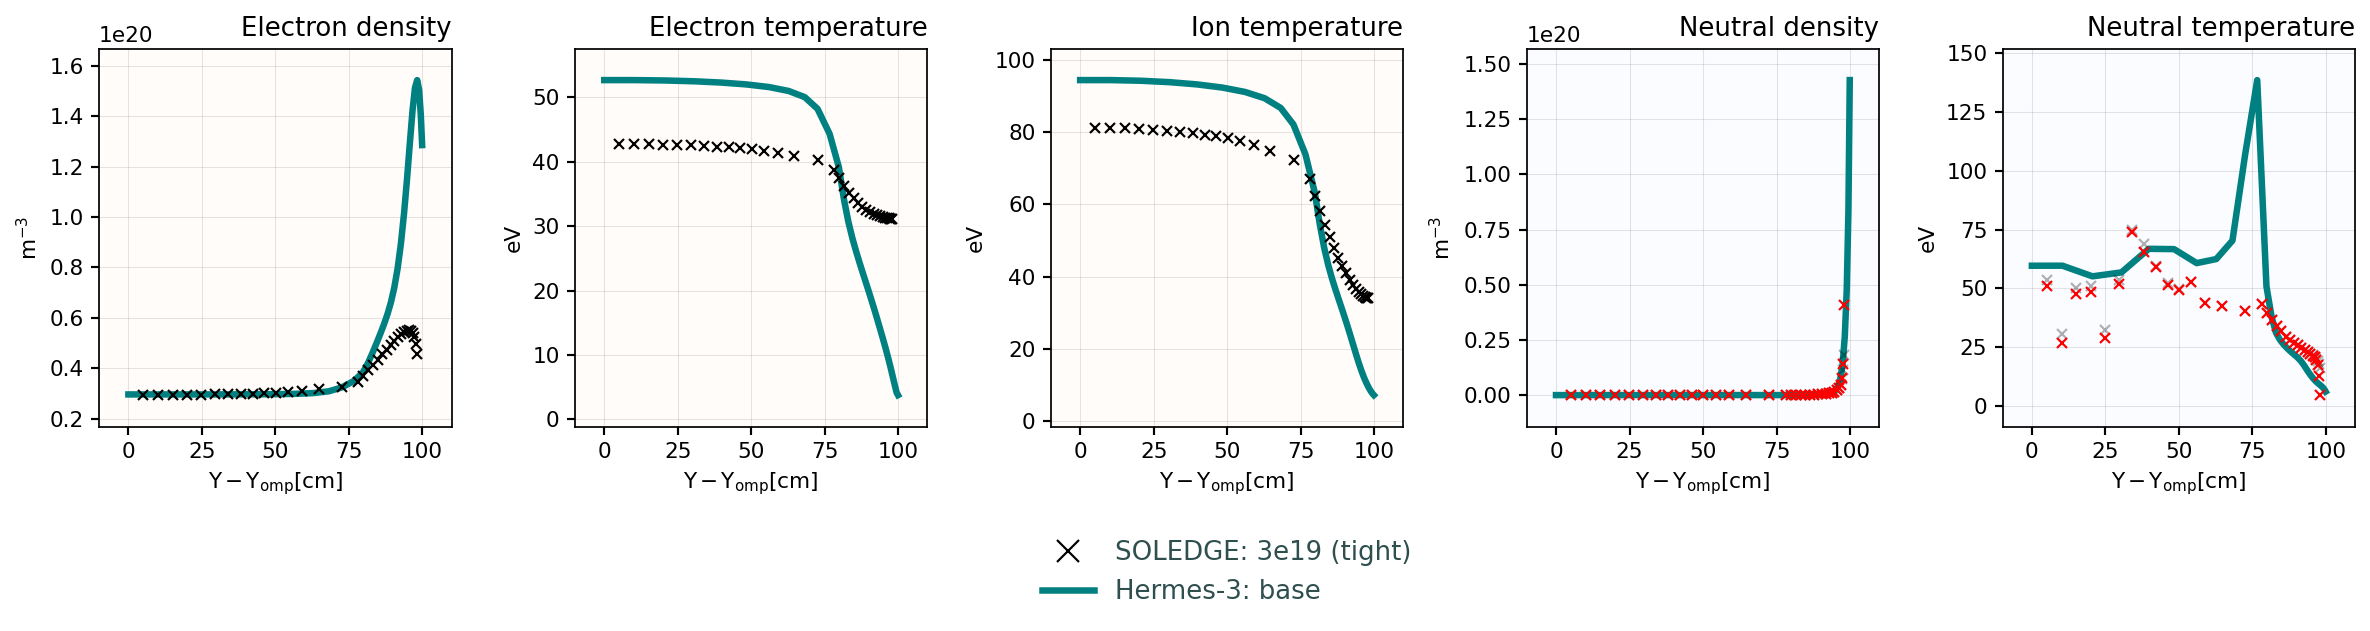

In [17]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 3e19 (tight)" : dict(data=sl["tightwall_3e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['afnE_3e19'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = True,
    mode = "linear",
    dpi = 120,
    lw = 2
)

In [10]:
print("\n## BASE")
calculate_simple_heat_balance(casestore["afnE_base"].ds.isel(t=-1))
print("\n## FIXES")
calculate_simple_heat_balance(casestore["afnE_fixes"].ds.isel(t=-1))
print()


## BASE
Wall reflective cooling:
inner_wall  : -0.009 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.083 [MW]
targets     : -0.038 [MW]
Total       : -0.207 [MW]

Recycling neutral energy source:
Total       : 0.417 [MW]

## FIXES
Wall reflective cooling:
inner_wall  : -0.011 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.078 [MW]
targets     : -0.064 [MW]
Total       : -0.232 [MW]

Recycling neutral energy source:
Total       : 0.407 [MW]



In [13]:
casestore.keys()

dict_keys(['afnE_base', 'afnE_fixes'])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


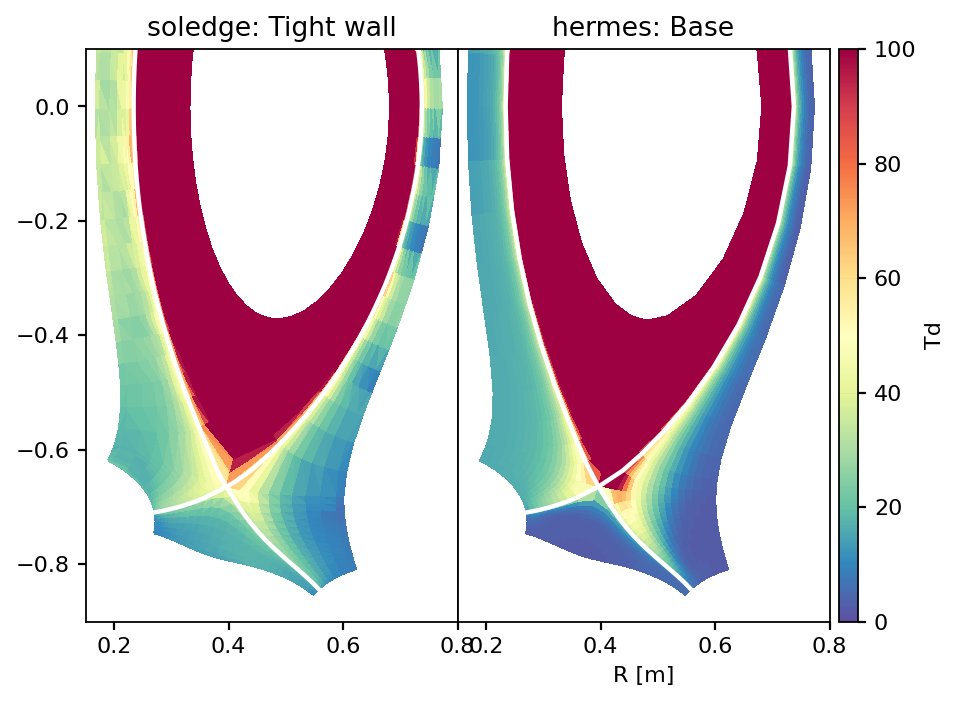

In [10]:
plt.close("all")
v = viewer_2d(
    "Td",
    [
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_3e19"]},
        {"name" : r"Base", "code" : "hermes", "ds" : casestore['afnE_3e19'].ds.isel(t=-1)},
        # {"name" : r"Fix neutbc", "code" : "hermes", "ds" : casestore['afnE_fixes'].ds.isel(t=-1)},
    ],
    logscale = False,
    vmin = 0,
    vmax = 100,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.1),
    xlim = (0.15, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r",
    slider = False,
)